In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm
from utils_evaluate_model import *

import random
from pathlib import Path
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import resize as tv_resize
from torch.nn.functional import pad as Fpad
import torchvision.transforms as T
from utils_ot import * 

In [28]:
if torch.cuda.is_available():
    device = torch.device('cuda:1')
    torch.cuda.FloatTensor
elif torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cuda:1


In [29]:
inception_model = InceptionV3_Multi(device=device)
inception_model.eval()

import torch.nn.functional as F

def preprocess_for_inception(x):
    # accepte x en [3,H,W] ou [N,3,H,W]
    was_3d = (x.dim() == 3)
    if was_3d:
        x = x.unsqueeze(0)          # → [1,3,H,W]
    x = (x + 1) / 2
    x = F.interpolate(x, size=(299,299), mode='bilinear', align_corners=False)
    mean = torch.tensor([0.485,0.456,0.406], device=x.device).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225], device=x.device).view(1,3,1,1)
    x = (x - mean) / std
    return x.squeeze(0) if was_3d else x



22 variantes, 5 niveaux chacune.


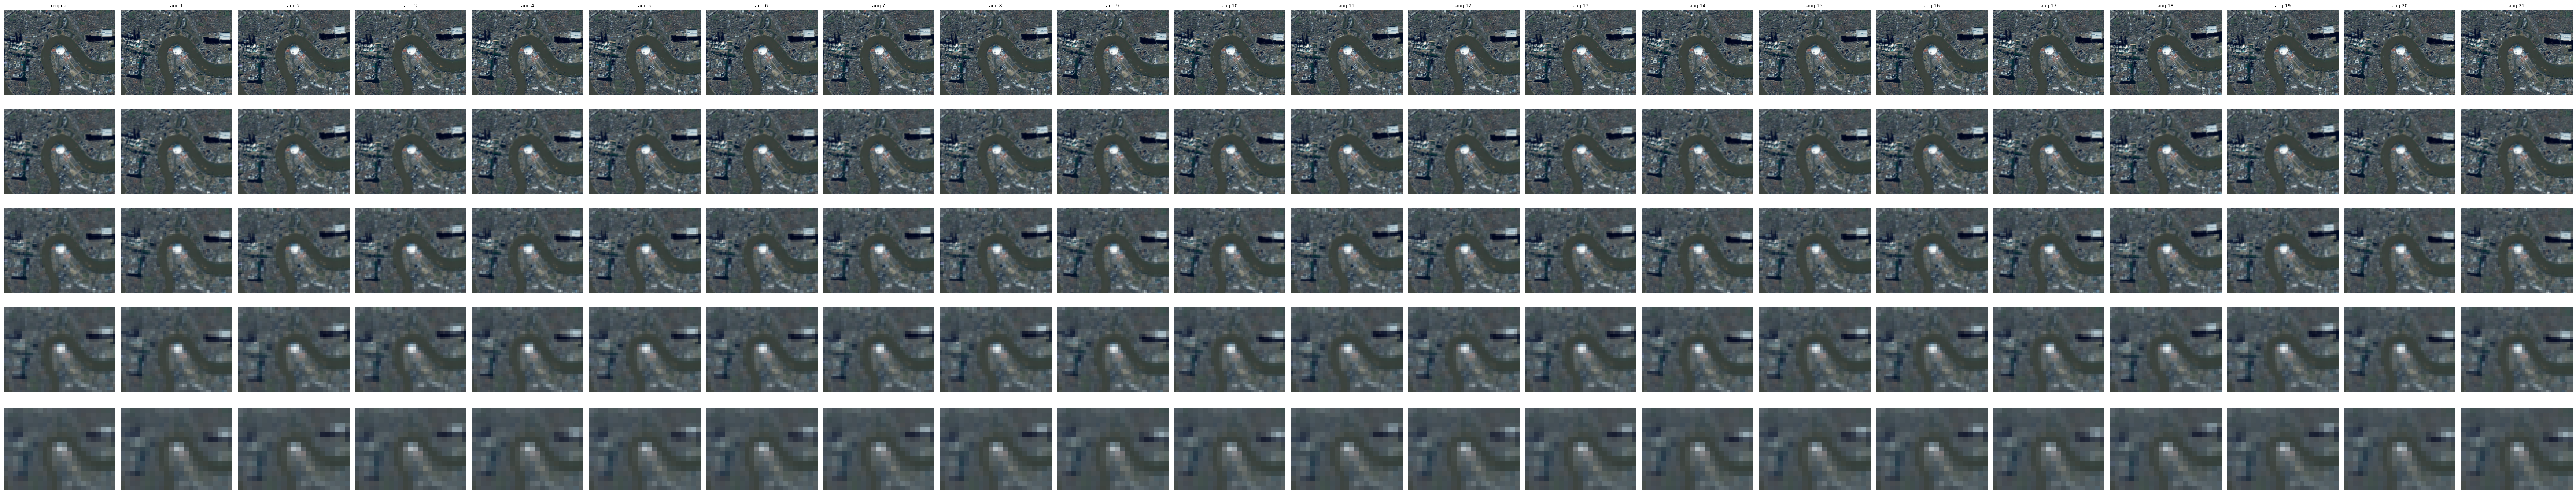

In [30]:
"""
SinGAN data-augmentation helper (torchvision.GaussianBlur)
──────────────────────────────────────────────────────────
• Produit l’image originale + N_AUG variantes aléatoires.
• Augmentations possibles :
      – pad réflectif + rotation aléatoire (sans bordures noires)
      – ColorJitter
• Chaque variante finit en 3×H×W, valeurs ∈ [-1, 1].
• Construit pour chacune la pyramide d’échelles façon SinGAN.
"""

IMG_PATH   = Path("images/london.jpg")             # image de référence
MAX_DIM    = 250        # côté le plus long après resize initial
MIN_DIM    = 25         # côté mini à l’échelle la plus coarse
RATIO      = 1.8      # facteur de downscale entre niveaux

N_AUG      = 21          # nombre de variantes à générer
MAX_ROT    = 5         # rotation ±MAX_ROT°
PAD_RATIO  = 0.20       # pad(reflect) = PAD_RATIO × taille

JITTER     = dict(brightness=0.25,
                  contrast=0.25,
                  saturation=0.25,
                  hue=0.1)

SEED       = 1       # fixer pour reproductibilité

# ------------------------------------------------------------
# 2. Bloc d’augmentation
# ------------------------------------------------------------
class AugmentVariant(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.jitter  = T.ColorJitter(**JITTER)
        
    @torch.no_grad()
    def forward(self, x):
        # x : 3×H×W ∈ [-1,1]
        C, H, W = x.shape

        # Pad-Rotate-Crop (pas de bordures noires)
        ph, pw = int(H * PAD_RATIO), int(W * PAD_RATIO)
        x = Fpad(x, (pw, pw, ph, ph), mode="reflect")
        angle = random.uniform(-MAX_ROT, MAX_ROT)
        x = TF.rotate(x, angle, expand=False)
        x = TF.center_crop(x, (H, W))

        # ColorJitter
        #x = self.jitter((x+1)/2) * 2 - 1

        return x.clamp(-1, 1)


torch.manual_seed(SEED) 
random.seed(SEED)

img   = Image.open(IMG_PATH).convert("RGB")
orig  = TF.to_tensor(img).to(device)                       # [0,1]
_, H0, W0 = orig.shape
scale = MAX_DIM / max(H0, W0)
orig  = tv_resize(orig, [int(H0*scale), int(W0*scale)], antialias=True)
orig  = orig * 2 - 1                            # [-1,1]


augmenter = AugmentVariant().to(device)
variants  = [orig] + [augmenter(orig.clone()) for _ in range(N_AUG)]

# ------------------------------------------------------------
# 5. Pyramides SinGAN
# ------------------------------------------------------------
def build_pyramid(img):
    levels = [img.unsqueeze(0)]              # fine → coarse (déjà sur device)
    while True:
        _, _, h, w = levels[-1].shape
        nh, nw = int(h / RATIO), int(w / RATIO)
        
        down = tv_resize(levels[-1], [nh, nw], antialias=True).to(device)  # <──
        levels.append(down)
        if nh < MIN_DIM or nw < MIN_DIM: break
    return levels

pyramids = [[lvl.to(device) for lvl in build_pyramid(v)] for v in variants]
print(f"{len(variants)} variantes, {len(pyramids[0])} niveaux chacune.")

# ------------------------------------------------------------
# 6. (Optionnel) Visualisation grille
# ------------------------------------------------------------
def show_grid(pyramids):
    rows, cols = len(pyramids[0]), len(pyramids)
    
    # Handle case with a single column (cols == 1) or multiple columns
    if cols == 1:
        fig, axes = plt.subplots(rows, 1, figsize=(3.2, 2.8 * rows))
    else:
        fig, axes = plt.subplots(rows, cols, figsize=(3.2 * cols, 2.8 * rows))
    
    # In case of a single column, axes is a 1D array, not a 2D array
    for r in range(rows):
        for c in range(cols):
            # Handle the case where there's only one column (axes is not a 2D array)
            if cols == 1:
                ax = axes[r]
            else:
                ax = axes[r, c]
            
            # Process the image
            img_np = (pyramids[c][r].cpu().squeeze(0).permute(1, 2, 0) + 1) / 2
            ax.imshow(img_np.clamp(0, 1))
            
            # Set the title for the top row
            if r == 0:
                ax.set_title("original" if c == 0 else f"aug {c}", fontsize=9)
            
            # Hide the axis ticks
            ax.axis('off')
    
    # Adjust the layout and show the plot
    plt.tight_layout()
    plt.show()

# Décommentez pour vérifier visuellement
show_grid(pyramids)


In [31]:
for x in pyramids[0] : 
    print(x.shape)
    print(x.device)

torch.Size([1, 3, 189, 250])
cuda:1
torch.Size([1, 3, 105, 138])
cuda:1
torch.Size([1, 3, 58, 76])
cuda:1
torch.Size([1, 3, 32, 42])
cuda:1
torch.Size([1, 3, 17, 23])
cuda:1


In [32]:
input_size_visu = (3, 1024, 1024)
netG_visu = Generator(n_hidden=32).to("cpu")
torchsummary.summary(netG_visu, input_size=input_size_visu,device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 3, 1024, 1024]             867
             Tanh-14        [-1, 3, 102

+ Générations des generateurs/discriminateurs

In [33]:
hidden_lowest_dim = 32
Genarators = []
N = len(pyramids[0])

for i in range(N):
    u = N-i
    Genarators.append(Generator( hidden_lowest_dim *  2**(u//4)).to(device))
   
for gen in Genarators : 
     print(gen.n_hidden)



64
64
32
32
32


In [34]:
with torch.no_grad():
    dummy = torch.randn(1, 3, 299, 299, device=device)
    feats = inception_model(dummy)      # liste de 3 tenseurs
for i, f in enumerate(feats):
    print(i, f.shape)


0 torch.Size([1, 288, 35, 35])
1 torch.Size([1, 768, 17, 17])
2 torch.Size([1, 2048, 8, 8])


+ Boucle d'entrainement 

torch.Size([22, 3, 17, 23])


scale 4:   0%|          | 0/2000 [00:00<?, ?it/s]

scale 4:  25%|██▍       | 498/2000 [00:16<00:49, 30.18it/s]

[it  500] λ=[0.4879513382911682, 0.6999999284744263, 0.9120486378669739]  swd=['0.014', '0.020', '0.230']  ratio=2.58  σ=9.66e-01  lr=1.0e-03


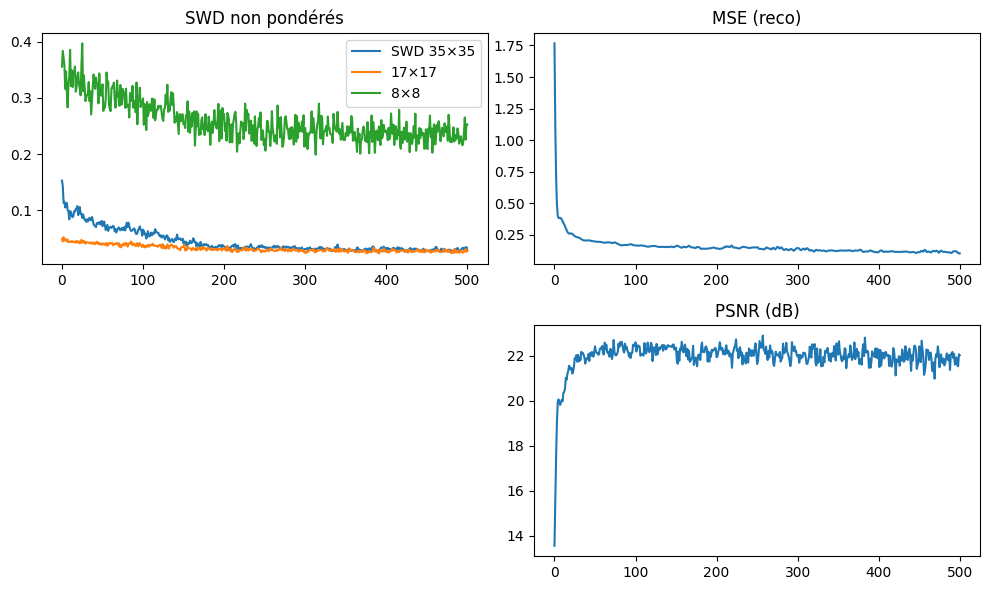

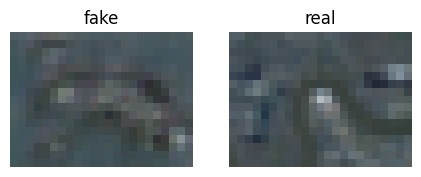

scale 4:  47%|████▋     | 949/2000 [00:31<00:36, 28.90it/s]

In [ ]:
# ----------------------------- paramètres -----------------------------
torch.random.manual_seed(1)

lr               = 1e-3
betas            = (0.9, 0.999)
base_iter        = 2000
alpha_rec        = 10.0
beta_sigma       = 0.1
b                = 4                     # batch‑size

# pondérations SWD : on les modifiera dynamiquement (GradNorm)
lambda_swd_init  = torch.tensor([0.4, 0.7, 1],device=device)   # (7c,6e,5d)
lambda_swd       = lambda_swd_init.clone()
lamda_swd_total  = 1.0

# pondération haute‑fréquence (HF)
lambda_hf_base = 0.05    # échelles > 0  (coarse, mid)
lambda_hf_last = 0.20    # échelle 0 (la plus fine)

debug = True



def psnr(fake, real, eps=1e-8):
    # images sont dans [-1,1] ⇒ plage = 2
    mse = F.mse_loss(fake, real)
    return 20 * torch.log10(2.0 / torch.sqrt(mse + eps))

# ----------------------------------------------------------------------


for G in Genarators:
    G.apply(weights_init)


def sigma_pos(raw):                      # softplus → σ>0
    return F.softplus(raw)

sigma_raw = nn.ParameterList([           # un scalaire par scale
    nn.Parameter(torch.zeros((), device=device)) 
    for _ in range(N)
])


# reset des optim.
optimizer_G = []
for i in range(N):
    params = (list(Genarators[i].parameters()) + [sigma_raw[i]])          
    optimizer_G.append(optim.Adam(params, lr=lr, betas=betas))


scheduler_G = []

step_size   = 20000        # when to trigger the decay
gamma       = 0.1            # multiplicative factor

for opt_G in optimizer_G:
    scheduler_G.append(
        torch.optim.lr_scheduler.StepLR(opt_G, step_size=step_size, gamma=gamma)
    )

z_star_shape = torch.stack([pyramids[i][-1].squeeze(0) for i in range(len(pyramids[:]))]).to(device)
z_star   = torch.randn_like(z_star_shape)               # bruit fixe
print(z_star.shape)
sigma_n  = [1.] * N
x_rec    = [None] * N
gen_image = [torch.zeros_like(pyramids[0][-1]).to(device)]
       


@torch.no_grad()
def regenerate_prev_full(k: int, b: int):
    """
    Renvoie prev_img pour l'échelle k (shape = (b, C, Hk, Wk)) :
      • on part d'une image nulle au coarse (N-1) ;
      • on applique tous les G gelés (N-1 … k+1) avec bruit propre à CHAQUE
        élément du batch ;
      • on upsample à la résolution k.
    """
    # ----------- 0. raccourci coarse ---------------------------------------
    if k == N - 1:                       # échelle la plus grossière
        _, C, Hc, Wc = pyramids[0][k].shape   # scales[k] == (1,C,H,W)
        return torch.zeros(b, C, Hc, Wc, device=device)

    # ----------- 1. point de départ (N-1) ----------------------------------
    _, C, Hc, Wc = pyramids[0][-1].shape
    img = torch.zeros(b, C, Hc, Wc, device=device)        # (b,C,Hc,Wc)
    sigma_val = sigma_pos(sigma_raw[N-1]).item() 
    z  = torch.randn_like(img) * sigma_val
    img = Genarators[N - 1](z)                            # (b,C,Hc,Wc)

    # ----------- 2. remontée N-2 … k+1 -------------------------------------
    for s in range(N - 2, k, -1):
        _, _, Hs, Ws = pyramids[0][s].shape

        # upsample vers la taille courante s
        img_up = F.interpolate(img, size=(Hs, Ws),
                               mode='bilinear', align_corners=False)

        # bruit propre à chaque élément du batch
        sigma_val = sigma_pos(sigma_raw[s]).item()        
        z = torch.randn_like(img_up) * sigma_val

        # passage résiduel : G_s(z + img_up) + img_up
        img = Genarators[s](z + img_up) + img_up

    # ----------- 3. dernier upsample vers l'échelle k ----------------------
    _, _, Hk, Wk = pyramids[0][k].shape
    prev_img = F.interpolate(img, size=(Hk, Wk),
                             mode='bilinear', align_corners=False)
    return prev_img 


# trainning toutes les scales
for n in range(N):
    current_res  = N - n - 1
    Gk = Genarators[current_res].train()

    # --- real images à cette échelle ------------------------------------
    total_real = torch.stack([
        pyramids[i][current_res].squeeze(0) for i in range(len(pyramids))
    ]).to(device)

    # cache les features Inception (no grad) -----------------------------
    with torch.no_grad():
        rp   = preprocess_for_inception(total_real)
        rf32 = inception_model(rp)
        real_feats_all = [f.detach() for f in rf32]   # liste len=3
    
    # if current_res < N-1:                          
    #     G_prev = Genarators[current_res + 1]

    #     def same_channels(net_a, net_b):
    #         """return True if first conv out-channels match"""
    #         for m_a, m_b in zip(net_a.modules(), net_b.modules()):
    #             if isinstance(m_a, torch.nn.Conv2d):
    #                 return m_a.out_channels == m_b.out_channels
    #         return False

    #     if same_channels(Gk, G_prev):              
    #         Gk.load_state_dict(G_prev.state_dict(), strict=True)
    #         if debug:
    #             print(f"[init] copied weights from scale {current_res+1} → {current_res}")

        
    # (re-attach the optimisers in case parameters were just overwritten)
    opt_G = optimizer_G[current_res]
    
    
    # Calcul ecart type nécessaire pour le bruit.
    if current_res < N-1:
        up_rec = F.interpolate(x_rec[current_res+1], size=total_real.shape[2:], mode='bilinear', align_corners=False)
        σ0 = beta_sigma * torch.sqrt(
                F.mse_loss(up_rec, total_real) /
                F.mse_loss(torch.zeros_like(total_real), total_real)
            )
    else:
        σ0 = torch.tensor(1., device=device)

    # convertit σ0 → raw tel que softplus(raw)=σ0
    sigma_raw[current_res].data.copy_(torch.log(torch.exp(σ0) - 1))
    total_loss_list = []
    Lrec_loss_list = []
    Sw_loss_list = []
    # avant iter_per_scale
    swd_raw_35, swd_raw_17, swd_raw_8 = [], [], []
    psnr_list = []

    # itérations par scale
    iter_per_scale = base_iter 
    
    
    for it in tqdm(range(iter_per_scale), desc=f"scale {current_res}", leave=False):
        # -------- pondérations SWD : cos‑ramp ---------------------------
        t  = it / (iter_per_scale - 1)
        mix = 0.5 - 0.5 * torch.cos(torch.tensor(t * 3.1415926535))
        lambda_swd_tmp = (1.0 - mix) * lambda_swd_init + mix * torch.flip(lambda_swd_init, dims=[0])

        idx = torch.randint(0, total_real.size(0), (b,), device=device)
        xk_real  = total_real[idx]
        real_f = [f.index_select(0, idx) for f in real_feats_all]

        # ---- générer fake ---------------------------------------------
        with torch.no_grad():
            prev_img = regenerate_prev_full(current_res, b)
        
        sigma_cur = F.softplus(sigma_raw[current_res])
        z         = torch.randn_like(prev_img) * sigma_cur
        fake      = Gk(z + prev_img) + prev_img

        fake_pre  = preprocess_for_inception(fake)
        fake_f    = inception_model(fake_pre)          # gradients actifs !

        # -------------- SWD + grad norm --------------------------------
        Sw_loss      = []
        # grad_norms   = []
        for i, (rf, ff, l) in enumerate(zip(real_f, fake_f, lambda_swd_tmp)):
            swd_i = sliced_wasserstein_distance(
                        preprocess_features(rf), preprocess_features(ff),
                        num_projections=128)
            if i == 2: swd_i_8  = swd_i   # Mixed_7c 8×8
            elif i == 1: swd_i_17 = swd_i # Mixed_6e
            else: swd_i_35 = swd_i        # Mixed_5d

            
            loss_i = l * swd_i
            Sw_loss.append(loss_i)
            # # norme de gradient w.r.t fake pour GradNorm (retain_graph=True)
            # g = torch.autograd.grad(loss_i, fake, retain_graph=True)[0]
            # grad_norms.append(g.norm().detach())

        # grad_norms = torch.stack(grad_norms)
        
        
       
        # # update dynamique tous les 50 pas
        # if it % 50 == 0 and it > 0:
        #     with torch.no_grad():
        #         eps = 1e-6                      # évite division par 0
        #         min_ratio, max_ratio = 0.2, 5.0 # borne le multiplicateur
        #         min_l, max_l = 0.05, 3.0        # borne absolue des λ

        #         target = grad_norms.mean()      # norme « souhaitée »

        #         for i in range(len(lambda_swd)):
        #             r = (target + eps) / (grad_norms[i] + eps)  # multiplicateur
        #             r = r.clamp(min_ratio, max_ratio)           # borne le ratio
        #             lambda_swd[i] *= r                          # mise à jour
        #         lambda_swd.clamp_(min_l, max_l)                 # borne finale
        #         lambda_swd /= lambda_swd.sum().detach()         # (option) renorm

        swd_total = lamda_swd_total * torch.stack(Sw_loss).sum()

        # -------------- recon & HF --------------------------------------
        if current_res == N-1:
            rec_in  = z_star
            rec_out = Gk(rec_in)
        else:
            up_fixed = F.interpolate(x_rec[current_res+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            rec_in   = up_fixed
            rec_out  = Gk(rec_in) + up_fixed

        Lrec_loss = alpha_rec * F.mse_loss(rec_out, total_real)
        
        if current_res == 0:            # dernière échelle (fine)
            lambda_hf_scale = lambda_hf_last
        else:
            lambda_hf_scale = lambda_hf_base

        

        total_loss = Lrec_loss + swd_total 
        # color_loss = 0.05*F.l1_loss(fake.mean([2,3]), xk_real.mean([2,3]))
        # total_loss += color_loss
        
        # -------- backward ---------------------------------------------
        optimizer_G[current_res].zero_grad()
        total_loss.backward()
        # clip (optionnel)
        torch.nn.utils.clip_grad_norm_(Gk.parameters(), 1.0)
        optimizer_G[current_res].step()
        scheduler_G[current_res].step()

            
        total_loss_list.append(total_loss.item()) 
        Lrec_loss_list.append(Lrec_loss.item())
        Sw_loss_list.append(swd_total.item())
                 # ----- SWD bruts non pondérés -----
        swd_raw_35.append(swd_i_35.item())   
        swd_raw_17.append(swd_i_17.item())
        swd_raw_8 .append(swd_i_8 .item())

        psnr_list.append(psnr(fake, xk_real).item())

        # logs
        if debug and ((it % 500 == 0  and it> 0 )or it==iter_per_scale-1):
            print(f"[it {it:4d}] "
                f"λ={lambda_swd_tmp.cpu().tolist()}  "
                f"swd={['%.3f'%l.item() for l in Sw_loss]}  "
                f"ratio={swd_total.item()/Lrec_loss.item():.2f}  "
                f"σ={sigma_cur.item():.2e}  "
                f"lr={opt_G.param_groups[0]['lr']:.1e}")

            plt.figure(figsize=(10,6))
            plt.subplot(2,2,1); plt.plot(swd_raw_35, label='SWD 35×35'); 
            plt.plot(swd_raw_17, label='17×17'); plt.plot(swd_raw_8, label='8×8')
            plt.legend(); plt.title('SWD non pondérés')

            plt.subplot(2,2,2); plt.plot(Lrec_loss_list); plt.title('MSE (reco)')

            plt.subplot(2,2,4); plt.plot(psnr_list); plt.title('PSNR (dB)')

            plt.tight_layout(); plt.show()

            with torch.no_grad():
                plt.figure(figsize=(8,2))                        
                # --- fake ---
                plt.subplot(1,3,1)
                plt.imshow(pil_from_minus1to1(fake[0].cpu()))
                plt.axis('off'); plt.title('fake')

                # --- real ---
                plt.subplot(1,3,2)
                plt.imshow(pil_from_minus1to1(xk_real[0].cpu()))
                plt.axis('off'); plt.title('real')
                
                plt.show()
    
    # fige G_k et stocke fake pour l’échelle au-dessus 
    with torch.no_grad():
        gen_image.append(fake[0].detach())
        sigma_final = F.softplus(sigma_raw[current_res]).item()  # valeur apprise
        sigma_n[current_res] = sigma_final 
        if current_res == N-1:
            x_rec[current_res] = Gk(z_star)                             # NEW (bruit fixe)
        else:
            up_rec_k = F.interpolate(x_rec[current_res+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            x_rec[current_res] = Gk(up_rec_k) + up_rec_k                 # NEW (bruit 0)
        Gk.eval()
        for p in Gk.parameters(): 
            p.requires_grad_(False)
    plt.figure(figsize=(6,4))
        
    plt.subplot(1,3,1)
    plt.plot(total_loss_list)
    plt.title("total loss")
    plt.subplot(1,3,2)
    plt.plot(Lrec_loss_list)
    plt.title("Lrec_loss")
    plt.subplot(1,3,3)
    plt.plot(Sw_loss_list)
    plt.title("SW_loss")

    plt.show()

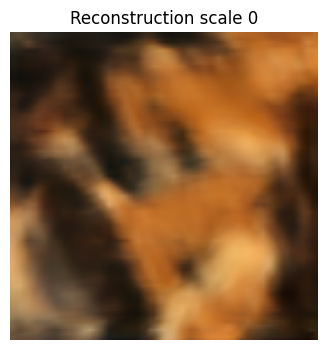

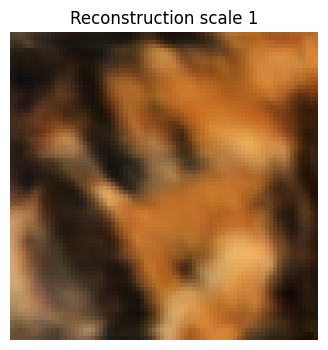

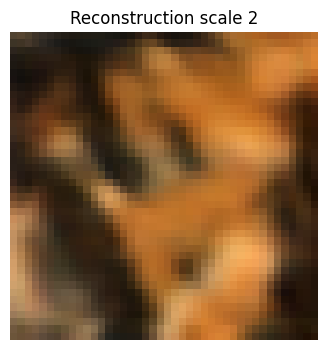

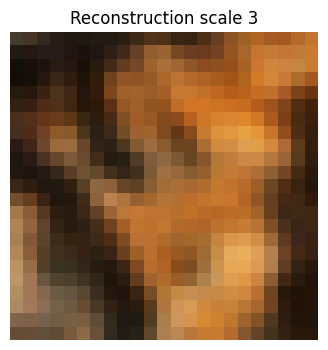

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_reconstructions(x_rec):
    for i, rec in enumerate(x_rec):
        if rec is None:
            continue
        img = rec[0].detach().cpu().squeeze()
        plt.figure(figsize=(4,4))
        plt.title(f"Reconstruction scale {i}")
        plt.imshow(pil_from_minus1to1(img))
        plt.axis('off')
        plt.show()

plot_reconstructions(x_rec[1:])

In [26]:
# ════════════════════════════════════════════════════════════════════════
#  Sauvegarde du modèle (GENERATEURS + σ + z⋆) – version « SWD / HF / MSE »
# ════════════════════════════════════════════════════════════════════════
import os, datetime, json, torch
from pathlib import Path

# ---- paramètres d’identification --------------------------------------
image_name = "non-gaussian"                # dossier racine
model_name = "SWD"                # sous-dossier
out_dir    = Path("models") / image_name / model_name
out_dir.mkdir(parents=True, exist_ok=True)

weights_fp = out_dir / "generators.pt"
descr_fp   = out_dir / "Description.txt"
sigma_fp   = out_dir / "sigma_n.json"
zstar_fp   = out_dir / "z_star.pt"

# -----------------------------------------------------------------------
# 1)  poids des générateurs (liste state_dict, ordre coarse→fine)
# -----------------------------------------------------------------------
torch.save([G.state_dict() for G in Genarators], weights_fp)
print(f"✓ générateurs sauvegardés  → {weights_fp}")

# -----------------------------------------------------------------------
# 2)  fichier texte de description
# -----------------------------------------------------------------------
description = {
    "date"           : datetime.datetime.now().isoformat(timespec="seconds"),
    "N_scales"       : N,
    "base_iter"      : base_iter,
    "lr"             : lr,
    "betas"          : betas,
    "alpha_rec"      : alpha_rec,
    "beta_sigma"     : beta_sigma,
    "lambda_swd_init": lambda_swd_init.tolist(),
    "lamda_swd_total": lamda_swd_total,
    "lambda_hf_base" : lambda_hf_base,
    "lambda_hf_last" : lambda_hf_last,
    "r" : RATIO,
    "comment"        : "Entraînement rapide SWD multi-échelle + HF + MSE, sans discriminateur."
}
with open(descr_fp, "w", encoding="utf-8") as f:
    for k, v in description.items():
        f.write(f"{k}: {v}\n")
print(f"✓ description écrite       → {descr_fp}")

# -----------------------------------------------------------------------
# 3)  σ_n  (liste flottants, du coarse vers le fine)
# -----------------------------------------------------------------------
sigma_list = [float(s.item() if torch.is_tensor(s) else s) for s in sigma_n]
with open(sigma_fp, "w", encoding="utf-8") as f:
    json.dump(sigma_list, f, indent=2)
print(f"✓ sigma_n sauvegardé       → {sigma_fp}")

# -----------------------------------------------------------------------
# 4)  z⋆  (bruit fixe utilisé pour la reconstruction)
# -----------------------------------------------------------------------
torch.save(z_star[0], zstar_fp)
print(f"✓ z_star sauvegardé        → {zstar_fp}")


✓ générateurs sauvegardés  → models/non-gaussian/SWD/generators.pt
✓ description écrite       → models/non-gaussian/SWD/Description.txt
✓ sigma_n sauvegardé       → models/non-gaussian/SWD/sigma_n.json
✓ z_star sauvegardé        → models/non-gaussian/SWD/z_star.pt
